In [0]:
from time import time
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [0]:
from google.colab import drive
drive.mount('/content/drive')
data = "/content/drive/My Drive/Colab Notebooks/face.mat"

In [0]:
faces = sio.loadmat(data)
X_train, X_test, y_train, y_test = [], [], [], []
for i in range(52):
    face_i = faces['X'][:, 10*i:10*(i+1)]
    label_i = faces['l'][:, 10*i:10*(i+1)]
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        face_i.T, label_i.T, test_size=0.2)
    X_train.append(X_train_temp)
    X_test.append(X_test_temp)
    y_train.append(y_train_temp)
    y_test.append(y_test_temp)    

In [0]:
# divide the training data equally into four subsets
X_train_A, X_train_B, X_train_C, X_train_D = [], [], [], []
for i in range(52):
  X_train_A.append(X_train[i][:2])
  X_train_B.append(X_train[i][2:4])
  X_train_C.append(X_train[i][4:6])
  X_train_D.append(X_train[i][6:8])

In [0]:
X_train_A = np.concatenate(X_train_A)
X_train_A = np.array(X_train_A)
X_train_B = np.concatenate(X_train_B)
X_train_B = np.array(X_train_B)
X_train_C = np.concatenate(X_train_C)
X_train_C = np.array(X_train_C)
X_train_D = np.concatenate(X_train_D)
X_train_D = np.array(X_train_D)

X_test = np.concatenate(X_test)
X_test = np.array(X_test)

In [0]:
y_train = np.concatenate(y_train)
y_train = np.array(y_train)

y_test = np.concatenate(y_test)
y_test = np.array(y_test)

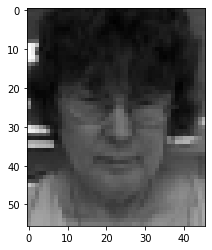

In [0]:
x = np.reshape(X_train_A[0], (46, 56))
plt.imshow(x.T, cmap='gist_gray')

In [0]:
N, px = X_train_A.shape
# average faces
mean_A, mean_B, mean_C, mean_D = np.zeros(px), np.zeros(px), np.zeros(px), np.zeros(px)
for faceA, faceB, faceC, faceD in zip(X_train_A, X_train_B, X_train_C, X_train_D):
  mean_A += faceA
  mean_B += faceB
  mean_C += faceC
  mean_D += faceD
mean_A = 1/N*mean_A
mean_B = 1/N*mean_B
mean_C = 1/N*mean_C
mean_D = 1/N*mean_D

# PCA with batch A

In [0]:
w_A = A.T.dot(evec_A.T)
w_A.shape

Running time: 0.008170366287231445s


In [0]:
# reconstruction of all faces
all_recon_faces = []
for i in range(w_A.shape[0]):
  recon_face = np.zeros(mean_A.shape)
  for a, eface in zip(w_A[i], evec_A):
    recon_face += a*eface
  recon_face += mean_A_N
  all_recon_faces.append(recon_face)

Running time: 0.07543277740478516s


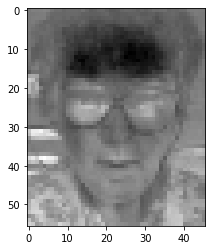

In [0]:
x = np.reshape(all_recon_faces[0], (46, 56))
plt.imshow(x.T, cmap='gist_gray')

# Confusion Matrix of PCA of A

In [0]:
# Compute matrix T for the testing images
T_A = [X_test[i]-mean_A for i in range(N)]
T_A = np.array(T_A)
T_A.shape

(104, 2576)

In [0]:
w_T_A = T_A.dot(evec_A.T)
w_T_A.shape

(104, 103)

In [0]:
# calculate predicted labels in A
y_pred = []
for test in w_T_A:
  min_e = float('inf')
  label = 0
  for i in range(N):
    error = np.linalg.norm(test-w_A[i])
    if error < min_e:
      min_e = error
      label = y_train_A[i][0]
  y_pred.append(label)

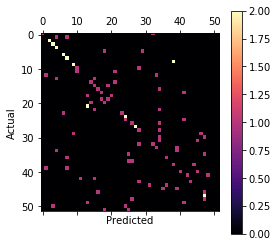

In [0]:
# confusion matrix for AB
from sklearn.metrics import confusion_matrix

y_actu = list(y_test.flatten())
cm = confusion_matrix(y_actu, y_pred)

plt.matshow(cm, cmap = 'magma')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
# Accuracy of batch A
print(acc(y_actu, y_pred))

32.69230769230769


# Incremental PCA with batches AB

In [0]:
# Combined mean
N_AB = 2*N
mean_AB = (N*mean_A + N*mean_B)/N_AB

# Combined covariance matrix
A = [X_train_A[i] - mean_A for i in range(N)]
A = np.array(A)
A = A.T
S_A = 1/N*A.dot(A.T)

B = [X_train_B[i] - mean_B for i in range(N)]
B = np.array(B)
B = B.T
S_B = 1/N*B.dot(B.T)

S_AB = N/N_AB*S_A + N/N_AB*S_B + (N*N/N_AB**2)*(mean_A-mean_B)*(mean_A-mean_B).T

In [0]:
# normalise the face A
face_avg = np.array(mean_A).reshape(2576, 1)
face_avg = normalize(face_avg, axis=0, norm='l1')
mean_A_N = np.concatenate(face_avg.T)
# normalise the face B
face_avg = np.array(mean_B).reshape(2576, 1)
face_avg = normalize(face_avg, axis=0, norm='l1')
mean_B_N = np.concatenate(face_avg.T)

In [0]:
# Eigenvectors of A & B
og_eval_A, og_evec_A = np.linalg.eig(S_A)
og_eval_B, og_evec_B = np.linalg.eig(S_B)

In [0]:
def normalise(matrix):
  mm = []
  for m in matrix:
    mm.append(np.real(m))
  mat = np.array(mm)

  return normalize(mat, axis=0, norm='l1')

In [0]:
# Only take the first 103 evec which correspond to non-zero eigenvalues
evec_A = og_evec_A.T[:103]
evec_B = og_evec_B.T[:103]

evec_A = normalise(evec_A)
evec_B = normalise(evec_B)

In [0]:
# Calculate the Gram-Schmidt orthogonalization of evec_A, evec_B and the difference of means
def gram_schmidt(v):
    basis = []
    w = v - np.sum( np.dot(v,b)*b  for b in basis )
    if (w > 1e-10).any():  
        basis.append(w/np.linalg.norm(w))
    return np.array(basis)[0]

concatenation = []
for a in evec_A:
  concatenation.append(a)
for b in evec_B:
  concatenation.append(b)
concatenation.append(mean_A_N-mean_B_N)

phi_AB = gram_schmidt(np.array(concatenation))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# Calculate the rotation matrix R
low_dim = phi_AB.dot(S_AB)
low_dim = low_dim.dot(phi_AB.T)
eval_AB, R_AB = np.linalg.eig(low_dim)

R_AB = normalise(R_AB)   # Normalise eigenvectors R. Use this function since it has a Re/Im format 

In [0]:
# Calculate eigenvector of S_AB
evec_AB = phi_AB.T.dot(R_AB)
# Normalise evec AB
evec_AB = normalize(evec_AB, axis=0, norm='l1')

# Face reconstruction AB




In [0]:
# Compute the weights for AB
X_train_AB = np.concatenate((X_train_A, X_train_B))
AB = [X_train_AB[i]-mean_AB for i in range(N_AB)]
AB = np.array(AB)

w_AB = AB.dot(evec_AB)
w_AB.shape

(208, 207)

In [0]:
# normalise the face AB
face_avg = np.array(mean_AB).reshape(2576, 1)
face_avg = normalize(face_avg, axis=0, norm='l1')
mean_AB_N = np.concatenate(face_avg.T)

In [0]:
# reconstruction of all faces
all_recon_faces_AB = []
for i in range(w_AB.shape[0]):
  recon_face = np.zeros(mean_AB.shape)
  for a, eface in zip(w_AB[i], evec_AB.T):
    recon_face += a*eface
  recon_face += mean_AB_N
  all_recon_faces_AB.append(recon_face)

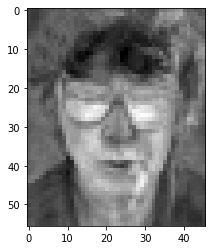

In [0]:
x = np.reshape(all_recon_faces_AB[1], (46, 56))
plt.imshow(x.T, cmap='gist_gray')

In [0]:
# Compute error per pixel for all images:
X_train_AB_N = normalise(X_train_AB)

# Frobenius form
fro_train_AB = np.linalg.norm(X_train_AB_N)
fro_rec_AB = np.linalg.norm(all_recon_faces_AB)
print(fro_train_AB, fro_rec_AB)

3.9148022351438136 17.821361314696873


# Confusion Matrix for IPCA of AB

In [0]:
# Compute matrix T for the testing images
T_AB = [X_test[i]-mean_AB for i in range(N)]
T_AB = np.array(T_AB)
T_AB.shape

(104, 2576)

In [0]:
w_T_AB = T_AB.dot(evec_AB)
w_T_AB.shape

(104, 207)

In [0]:
# Modify y_train according to the number of batches used
y_train_A = []
n_batches = 1
for k in range(52):
  same_labels = y_train[8*k : 8*(k+1)]
  y_train_A.append(same_labels[:2*n_batches])
y_train_A = np.concatenate(y_train_A)

y_train_AB = np.concatenate((y_train_A, y_train_A))

In [0]:
# calculate predicted labels in AB
y_pred = []
for test in w_T_AB:
  min_e = float('inf')
  label = 0
  for i in range(N_AB):
    error = np.linalg.norm(test-w_AB[i])
    if error < min_e:
      min_e = error
      label = y_train_AB[i][0]
  y_pred.append(label)

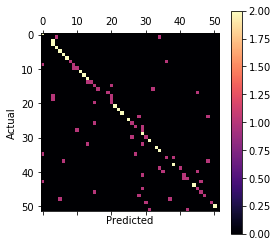

In [0]:
# confusion matrix for AB
from sklearn.metrics import confusion_matrix

y_actu = list(y_test.flatten())
cm = confusion_matrix(y_actu, y_pred)

plt.matshow(cm, cmap = 'magma')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
def acc(y_actu, y_pred):
  correct_labels = 0
  for actu, pred in zip(y_actu, y_pred):
    correct_labels = correct_labels + 1 if actu == pred else correct_labels

  return correct_labels / len(y_actu) * 100

In [0]:
# Compute accuracy of AB
print(acc(y_actu, y_pred))

54.807692307692314


# Incremental PCA with batches ABC

In [0]:
# Combined mean
N_ABC = 3*N
mean_ABC = (N_AB*mean_AB + N*mean_C)/N_ABC

# Combined covariance matrix
C = [X_train_C[i] - mean_C for i in range(N)]
C = np.array(C)
C = C.T
S_C = 1/N*C.dot(C.T)

S_ABC = N_AB/N_ABC*S_AB + N/N_ABC*S_C + (N_AB*N/N_ABC**2)*(mean_AB-mean_C)*(mean_AB-mean_C).T

In [0]:
# normalise the face C
face_avg = np.array(mean_C).reshape(2576, 1)
face_avg = normalize(face_avg, axis=0, norm='l1')
mean_C_N = np.concatenate(face_avg.T)

In [0]:
# Eigenvectors of C
og_eval_C, og_evec_C = np.linalg.eig(S_C)

In [0]:
# Only take the first 103 evec which correspond to non-zero eigenvalues
evec_C = og_evec_C.T[:103]

evec_C = normalise(evec_C)

In [0]:
# Calculate the Gram-Schmidt orthogonalization of evec_AB, evec_C and the difference of means
concatenation = []
for a in evec_AB.T:
  concatenation.append(a)
for c in evec_C:
  concatenation.append(c)
concatenation.append(mean_AB_N-mean_C_N)

phi_ABC = gram_schmidt(np.array(concatenation))

In [0]:
# Calculate the rotation matrix R
low_dim = phi_ABC.dot(S_ABC)
low_dim = low_dim.dot(phi_ABC.T)
eval_ABC, R_ABC = np.linalg.eig(low_dim)

R_ABC = normalise(R_ABC)

In [0]:
# Calculate eigenvector of S_ABC
evec_ABC = phi_ABC.T.dot(R_ABC)
# Normalise evec ABC
evec_ABC = normalize(evec_ABC, axis=0, norm='l1')

# Face reconstruction ABC

In [0]:
# Compute the weights for ABC
X_train_ABC = np.concatenate((X_train_AB, X_train_C))
ABC = [X_train_ABC[i]-mean_ABC for i in range(N_ABC)]
ABC = np.array(ABC)

w_ABC = ABC.dot(evec_ABC)
w_ABC.shape

(312, 311)

In [0]:
# normalise the face AB
face_avg = np.array(mean_ABC).reshape(2576, 1)
face_avg = normalize(face_avg, axis=0, norm='l1')
mean_ABC_N = np.concatenate(face_avg.T)

In [0]:
# reconstruction of all faces
all_recon_faces_ABC = []
for i in range(w_ABC.shape[0]):
  recon_face = np.zeros(mean_ABC.shape)
  for a, eface in zip(w_ABC[i], evec_ABC.T):
    recon_face += a*eface
  recon_face += mean_ABC_N
  all_recon_faces_ABC.append(recon_face)

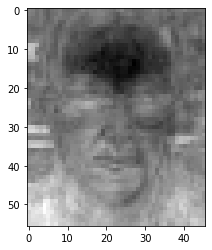

In [0]:
x = np.reshape(all_recon_faces_ABC[0], (46, 56))
plt.imshow(x.T, cmap='gist_gray')

In [0]:
# Compute error per pixel for all images:
X_train_ABC_N = normalise(X_train_ABC)

# Frobenius form
fro_train_ABC = np.linalg.norm(X_train_ABC_N)
fro_rec_ABC = np.linalg.norm(all_recon_faces_ABC)
print(fro_train_ABC, fro_rec_ABC)

3.201514363303108 22.16529624709466


# Confusion Matrix for IPCA of ABC

In [0]:
# Compute matrix T for the testing images
T_ABC = [X_test[i]-mean_ABC for i in range(N)]
T_ABC = np.array(T_ABC)
T_ABC.shape

(104, 2576)

In [0]:
w_T_ABC = T_ABC.dot(evec_ABC)
w_T_ABC.shape

(104, 311)

In [0]:
y_train_ABC = np.concatenate((y_train_A, y_train_A, y_train_A))

In [0]:
# calculate predicted labels in ABC
y_pred = []
for test in w_T_ABC:
  min_e = float('inf')
  label = 0
  for i in range(N_ABC):
    error = np.linalg.norm(test-w_ABC[i])
    if error < min_e:
      min_e = error
      label = y_train_ABC[i][0]
  y_pred.append(label)

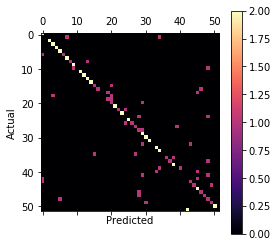

In [0]:
# confusion matrix for ABC
from sklearn.metrics import confusion_matrix

y_actu = list(y_test.flatten())
cm = confusion_matrix(y_actu, y_pred)

plt.matshow(cm, cmap = 'magma')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
# Accuracy of IPCA of ABC
print(acc(y_actu, y_pred))

59.61538461538461


# Incremental PCA with batches ABCD

In [0]:
# Combined mean
N_ABCD = 4*N
mean_ABCD = (N_ABC*mean_ABC + N*mean_D)/N_ABCD

# Combined covariance matrix
D = [X_train_D[i] - mean_D for i in range(N)]
D = np.array(D)
D = D.T
S_D = 1/N*D.dot(D.T)

S_ABCD = N_ABC/N_ABCD*S_ABC + N/N_ABCD*S_D + (N_ABC*N/N_ABCD**2)*(mean_ABC-mean_D)*(mean_ABC-mean_D).T

In [0]:
start = time()
# normalise the face D
face_avg = np.array(mean_D).reshape(2576, 1)
face_avg = normalize(face_avg, axis=0, norm='l1')
mean_D_N = np.concatenate(face_avg.T)
end = time()

In [0]:
og_eval_D, og_evec_D = np.linalg.eig(S_D)

In [0]:
# Only take the first 103 evec which correspond to non-zero eigenvalues
evec_D = og_evec_D.T[:103]

evec_D = normalise(evec_D)

In [0]:
# Calculate the Gram-Schmidt orthogonalization of evec_ABC, evec_D and the difference of means
concatenation = []
for a in evec_ABC.T:
  concatenation.append(a)
for d in evec_D:
  concatenation.append(d)
concatenation.append(mean_ABC_N-mean_D_N)

phi_ABCD = gram_schmidt(np.array(concatenation))

In [0]:
# Calculate the rotation matrix R
low_dim = phi_ABCD.dot(S_ABCD)
low_dim = low_dim.dot(phi_ABCD.T)
eval_ABCD, R_ABCD = np.linalg.eig(low_dim)

R_ABCD = normalise(R_ABCD) 

In [0]:
# Calculate eigenvector of S_AB
evec_ABCD = phi_ABCD.T.dot(R_ABCD)
# Normalise evec ABCD
evec_ABCD = normalize(evec_ABCD, axis=0, norm='l1')

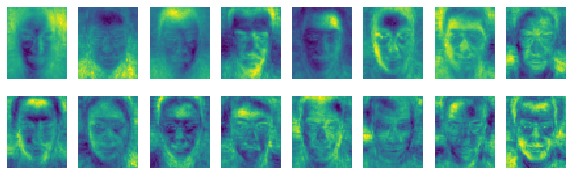

In [0]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=5
fig=plt.figure(figsize=(10, 3))
columns = 8
rows = 2
for i in range(1, columns*rows +1):
    img = np.reshape(evec_ABCD.T[i], (46, 56))
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img.T)
plt.show()

# Face reconstruction ABCD

In [0]:
# Compute the weights for ABCD
X_train_ABCD = np.concatenate((X_train_ABC, X_train_D))
ABCD = [X_train_ABCD[i]-mean_ABCD for i in range(N_ABCD)]
ABCD = np.array(ABCD)

w_ABCD = ABCD.dot(evec_ABCD)
w_ABCD.shape

(416, 415)

In [0]:
# normalise the face ABCD
face_avg = np.array(mean_ABCD).reshape(2576, 1)
face_avg = normalize(face_avg, axis=0, norm='l1')
mean_ABCD_N = np.concatenate(face_avg.T)

In [0]:
# reconstruction of all faces
all_recon_faces_ABCD = []
for i in range(w_ABCD.shape[0]):
  recon_face = np.zeros(mean_ABCD.shape)
  for a, eface in zip(w_ABCD[i], evec_ABCD.T):
    recon_face += a*eface
  recon_face += mean_ABCD_N
  all_recon_faces_ABCD.append(recon_face)

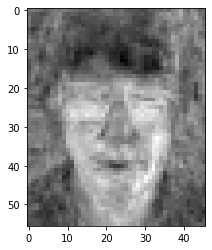

In [0]:
x = np.reshape(all_recon_faces_ABCD[1], (46, 56))
plt.imshow(x.T, cmap='gist_gray')

In [0]:
# Compute error per pixel for all images:
X_train_ABCD_N = normalise(X_train_ABCD)

# Frobenius form
fro_train_ABCD = np.linalg.norm(X_train_ABCD_N)
fro_rec_ABCD = np.linalg.norm(all_recon_faces_ABCD)
print(fro_train_ABCD, fro_rec_ABCD)

2.774921571922563 24.68614706655822


# Confusion Matrix for IPCA of ABCD

In [0]:
# Compute matrix T for the testing images
T_ABCD = [X_test[i]-mean_ABCD for i in range(N)]
T_ABCD = np.array(T_ABCD)
T_ABCD.shape

(104, 2576)

In [0]:
w_T_ABCD = T_ABCD.dot(evec_ABCD)
w_T_ABCD.shape

(104, 415)

In [0]:
y_train_ABCD = np.concatenate((y_train_A, y_train_A, y_train_A, y_train_A))

In [0]:
# calculate predicted labels in ABC
y_pred = []
for test in w_T_ABCD:
  min_e = float('inf')
  label = 0
  for i in range(N_ABCD):
    error = np.linalg.norm(test-w_ABCD[i])
    if error < min_e:
      min_e = error
      label = y_train_ABCD[i][0]
  y_pred.append(label)

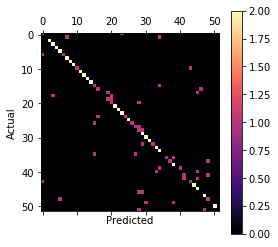

In [0]:
# confusion matrix for ABC
from sklearn.metrics import confusion_matrix

y_actu = list(y_test.flatten())
cm = confusion_matrix(y_actu, y_pred)

plt.matshow(cm, cmap = 'magma')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
# Accuracy of IPCA of ABCD
print(acc(y_actu, y_pred))

64.42307692307693
